# Determining Peak Parameters From Inelastic Neutron Scattering Data

## Parameters and Data

We would like to determine the magnitides and widths of both the central Rayleigh peak and the inelastic excitation. We would also like to determine the location of the excitation. 
We have a full intensity curve at 1203 K as our data.

## Approach


We use Bayes theorem to relate the posterior to our prior beliefs about the parameters and the likelihood that we would observe the data given each of our hypotheses. 
Formally we have, 

\begin{equation}
   P(A_0, \{A_i, y_i\} |M, \{D_k\}) \propto P(A_0, \{A_i, y_i\} |M) \times P(\{D_k\} | A_0, \{A_i, y_i\}, M)
\end{equation}

The likelihood measures the relative likelihood that we would obtain our data for each point in parameter space. Multiplying it by the prior updates our beliefs about the underlying PDF after viewing the data. 

We assume the greatest amount of ignorance about our parameter values by setting the prior constant,

\begin{equation}
   P(A_0, \{A_i, y_i\} |M) = constant
\end{equation}
The posterior is then proportional to the likelihood. All that is left to do is calculate this likelihood function.

Instead of maximizing the likelihood we minimize the negative of the log of the likelihood. Let $\vec{X} = \{A_0, \{A_i, y_i\}\}$ to reduce clutter. 
\begin{equation}
   P(\{D_k\} | \vec{X}, M)\nonumber
\end{equation}
\begin{equation}
  = P(\{S_k\}, \{\omega_k\}, \{\sigma_k\} | \vec{X}, M)
\end{equation}
\begin{equation}
   = P(\{\omega_k\}) \times P(\{\sigma_k\} | \{\omega_k\}) \times P(\{S_k\} | \{\omega_k\}, \{\sigma_k\}, \vec{X}, M)
\end{equation}
\begin{equation}
   = \prod_{k=1}^{N} P(\omega_k) \times P(\sigma_k\ | \omega_k) \times P(S_k | \omega_k, \sigma_k, \vec{X}, M)
\end{equation}
\begin{equation}
   = \prod_{k=1}^{N} P(\omega_k) \times P(\sigma_k\ | \omega_k) \times \frac{1}{\sqrt{2\pi}}\exp{-\frac{1}{2}\left(\frac{S_k - \mu_k}{\sigma_k}\right)^2}
\end{equation}

Taking the negative natural log yields,
\begin{equation}
   -log(P(\{D_k\} | \vec{X}, M))\nonumber
\end{equation}
\begin{equation}
   = \sum_{k=1}^{N} \left[-logP(\omega_k) -logP(\sigma_k|\omega_k) -log\left(\frac{1}{\sqrt{2\pi}}\right) + \frac{1}{2}\left(\frac{S_k - \mu_k}{\sigma_k}\right)^2\right]
\end{equation}
\begin{equation}
   = constant + \sum_{k=1}^{N} \frac{1}{2}\left(\frac{S_k - \mu_k}{\sigma_k}\right)^2
\end{equation}

We therefore minimize,
\begin{equation}
   \sum_{k=1}^{N} \frac{1}{2}\left(\frac{S_k - \mu_k}{\sigma_k}\right)^2
\end{equation}
where,
$\mu_k$ is given by equation 1 in this paper: https://journals.aps.org/prb/abstract/10.1103/PhysRevB.63.134205

## Minimization
We use gradient descent to perform the minimization. The 1-D marginalized error bars are calculated from the covariance matrix.  

In [16]:
import matplotlib.pylab as pylab
params = {
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

## Loading and Plotting the Data
I added error bars

<function matplotlib.pyplot.show(*args, **kw)>

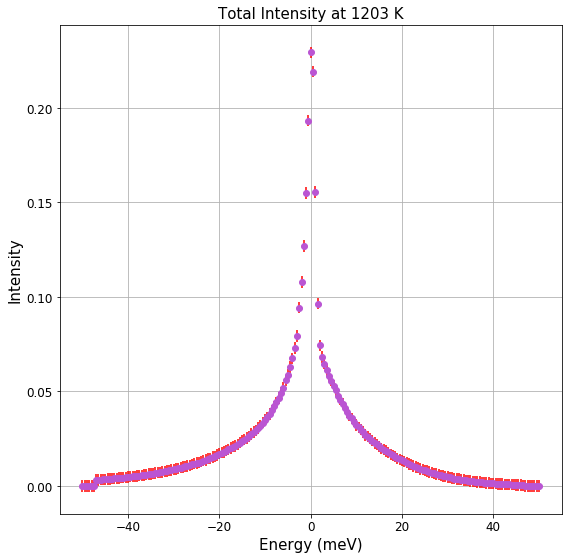

In [17]:
import math
pi = math.pi
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

filepath = 'ie_unnorm_1203K_cooling.dat'
W = []
S = []
E = []

with open(filepath) as fp:
    line = fp.readline()
    cnt = 1
    while line:
        W.append(float(line.split()[0]))
        S.append(float(line.split()[1]))
        E.append(0.003)
        line = fp.readline()
        cnt += 1

plt.figure(figsize=(9, 9))
plt.grid(True, which='major')
plt.plot(W, S, 'o', color='mediumorchid')
plt.errorbar(W, S, yerr=E, fmt=' ', color='red')
plt.title('Total Intensity at 1203 K', size=15)
plt.xlabel('Energy (meV)', size=15)
plt.ylabel('Intensity', size=15)
plt.show

## Coding the Posterior and Minimizing

In [18]:
from scipy.constants import hbar, Boltzmann, pi
def f(X):
    A_0 = X[0]
    gamma_0 = X[1]
    A_q = X[2]
    omega_q = X[3]
    gamma_q = X[4]
    res = 0
    for k in range(len(W)):
        if W[k] == 0:
            continue
        u = (2 / (1 + np.exp((-hbar*W[k]) / (Boltzmann*1203)))) * (A_0/pi)* (gamma_0/(W[k]**2+gamma_0**2)) + ((1/(1-np.exp((-hbar*W[k])/(Boltzmann*1203))))*(hbar/(2*Boltzmann*1203))) * (A_q/pi)*((4*W[k]*omega_q*gamma_q)/((W[k]**2-omega_q**2)**2 + 4*gamma_q**2*W[k]**2))
        res = res + 0.5*(((S[k] - u) / E[k])**2)
    return res

In [19]:
from scipy.optimize import minimize
res = minimize(f, (2, 40, 2, 5, 20), options={'gtol':0.004})
print(res.x)
print(res)
print(np.sqrt(res.hess_inv[0][0]), np.sqrt(res.hess_inv[1][1]), np.sqrt(res.hess_inv[2][2]), np.sqrt(res.hess_inv[3][3]), np.sqrt(res.hess_inv[4][4]))


[ 2.03482872 11.17096969  3.41772591  5.97628808 18.18381262]
      fun: 162.4322774845601
 hess_inv: array([[ 9.08701093e-04,  2.56978758e-03, -3.21642404e-02,
        -5.20109855e-02, -3.03355952e-01],
       [ 2.56978758e-03,  9.97891720e-02, -9.84194019e-02,
        -1.95482610e-01, -1.25725881e+00],
       [-3.21642404e-02, -9.84194019e-02,  2.79926483e+00,
         4.61114486e+00,  2.71740732e+01],
       [-5.20109855e-02, -1.95482610e-01,  4.61114486e+00,
         7.61561925e+00,  4.49413826e+01],
       [-3.03355952e-01, -1.25725881e+00,  2.71740732e+01,
         4.49413826e+01,  2.65560214e+02]])
      jac: array([-3.62777710e-03,  3.66210938e-04, -1.18637085e-03,  3.39508057e-04,
        4.76837158e-05])
  message: 'Optimization terminated successfully.'
     nfev: 357
      nit: 41
     njev: 51
   status: 0
  success: True
        x: array([ 2.03482872, 11.17096969,  3.41772591,  5.97628808, 18.18381262])
0.03014466939301626 0.31589424178270115 1.6731003659769752 2.75964114

## Results
We find that 

A_0 = 2.03482872 +- 0.030144669

gamma_0 = 11.17096969 +- 0.315894241
    
A_q = 3.41772591 +- 1.673100365
    
omega_q = 5.97628808 +- 2.75964114

gamma_q = 18.18381262 +- 16.2960183


## Plotting the Fit Over the Data

Text(0, 0.5, 'Intensity')

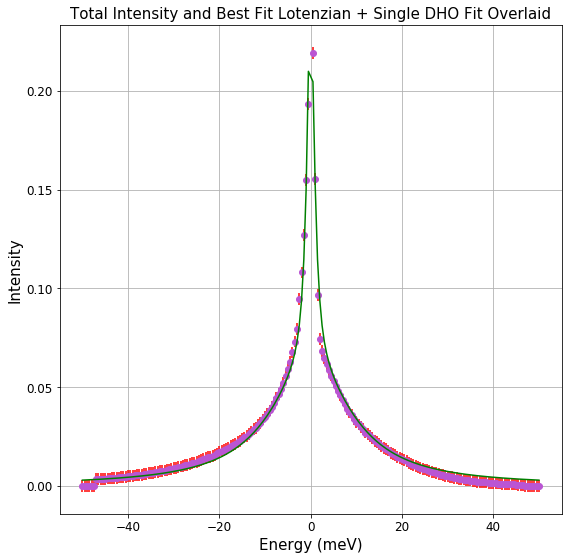

In [21]:
W2 = []
S2 = []
E2 = []
for i in range(len(W)):
    if not W[i]:
        continue
    W2.append(W[i])
    S2.append(S[i])
    E2.append(E[i])
    
po = [((2 / (1 + np.exp((-hbar*test) / (Boltzmann*1203)))) 
         * (res.x[0]/pi) * (res.x[1]/(test**2+res.x[1]**2)) 
         + ((1/(1-np.exp((-hbar*test)/(Boltzmann*1203))))*(hbar/(2*Boltzmann*1203))) 
         * (res.x[2]/pi)*((4*test*res.x[3]*res.x[4])/((test**2-res.x[3]**2)**2 + 4*res.x[4]**2*test**2))) for test in W2]
        
plt.figure(figsize=(9, 9))
plt.grid(True, which='major')
plt.plot(W2, S2, 'o', color='mediumorchid')
plt.errorbar(W2, S2, yerr=E2, fmt=' ', color='red')
plt.plot(W2, po, color='green')
plt.title('Total Intensity and Best Fit Lotenzian + Single DHO Fit Overlaid', size=15)
plt.xlabel('Energy (meV)', size=15)
plt.ylabel('Intensity', size=15)

## Discussion
It seems like the fit is poor when considering only a single inelastic peak DHO. 

The fit skews away from the data around the right tail, corroborating the large standard deviations we see. 

We believe this means that there must be more than one inelastic DHO contribution. 

We must also account for the instrument resolution function. 